In [446]:


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime as dt

from sklearn.experimental import enable_iterative_imputer


from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBRegressor

from sklearn.preprocessing import OrdinalEncoder
os.getcwd()


'/Users/chiomanwuzi/jupyter_env'

In [447]:
 # import data sets

soda_data =  pd.read_csv(str(os.getcwd()) + "/soft_drink_sales.csv")
#lower the case of the columns 
soda_data.columns = soda_data.columns.str.lower()

benchmark_data = pd.read_csv(str(os.getcwd()) + "/benchmarks.csv")


In [448]:
#no missing values

benchmark_data.info()
benchmark_data.isnull().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   yearmon    12 non-null     object 
 1   benchmark  12 non-null     float64
dtypes: float64(1), object(1)
memory usage: 324.0+ bytes


yearmon      0
benchmark    0
dtype: int64

In [449]:

#normalize the data columns between the tables
soda_data['yearmon'] = '20' + soda_data['transaction_date'].str.split('/').str[-1] +'-' + soda_data['transaction_date'].str.split('/').str[0]
soda_data['yearmon'] = soda_data['yearmon'].apply(lambda x: str(x) if len(str(x)) == 7 else str(x)[:5] + '0' + str(x)[5:])
soda_data[['year', 'month']] = soda_data['yearmon'].str.split('-', expand=True)


In [450]:
#index user_id, check for missing values

soda_data.set_index('user_id')
soda_data.info()
soda_data.isnull().sum() 
# 30 missing values for total spent

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29798 entries, 0 to 29797
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             29798 non-null  int64  
 1   demographic_weight  29798 non-null  float64
 2   basket_id           29798 non-null  int64  
 3   channel             29798 non-null  object 
 4   total_spent         29768 non-null  float64
 5   total_units         29798 non-null  int64  
 6   trips               29798 non-null  int64  
 7   transaction_date    29798 non-null  object 
 8   yearmon             29798 non-null  object 
 9   year                29798 non-null  object 
 10  month               29798 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 2.5+ MB


user_id                0
demographic_weight     0
basket_id              0
channel                0
total_spent           30
total_units            0
trips                  0
transaction_date       0
yearmon                0
year                   0
month                  0
dtype: int64

In [451]:
# imputation of missing values

impute_method = IterativeImputer(max_iter = 5, random_state = 127)
imputed_values = impute_method.fit_transform(soda_data.iloc[:,~soda_data.columns.isin(['user_id','basket_id', 'channel', 'transaction_date', 'yearmon'])])
imputed_df = pd.DataFrame(imputed_values)


In [452]:
#readjust the names of the imputed columns

imputed_df.columns = ["demographic_weight","total_spent", "total_units","trips"	,"year","month"]

In [453]:
#merge the imputed df with original df

soda_final = soda_data.merge(imputed_df, left_index = True, right_index = True)
soda_final = soda_final.iloc[:, ~soda_final.columns.isin(['demographic_weight_x','total_spent_x', 'total_units_x', 'trips_x','year_x', 'month_x' ])]
soda_final.columns = ['user_id', 'basket_id', 'channel', 'transaction_date', 'yearmon','demographic_weight', 'total_spent', 'total_units', 'trips','year', 'month']

In [454]:
#create a aggregate table for the sum of the table spent of the ledgar, and the proportion of the total spend compated to the
#benchmark grouped monthly

sum_sales = soda_final.groupby(['yearmon'])['total_spent'].sum().sort_values() 
sum_sales = pd.DataFrame(sum_sales)

sum_sales = sum_sales.merge(benchmark_data, on = "yearmon").sort_values(by = "yearmon")
sum_sales['coverage_rate'] = sum_sales['total_spent']/sum_sales['benchmark'] * 100
sum_sales.columns = ["yearmon","agg_total_spent","benchmark","coverage_rate"]
sum_sales

,yearmon,agg_total_spent,benchmark,coverage_rate
0,2020-09,5933.632008,27679494.20,0.021437
2,2020-10,6292.137490,28609704.69,0.021993
10,2020-11,11692.740000,26112555.30,0.044778
3,2020-12,6336.088666,28118388.16,0.022534
4,2021-01,6757.107507,32346220.25,0.020890
1,2021-02,6038.354942,26890723.54,0.022455
11,2021-03,12110.894493,33822787.61,0.035807
5,2021-04,8222.600802,39701515.10,0.020711
7,2021-05,8543.070035,41399845.79,0.020636
6,2021-06,8271.714083,34532116.99,0.023954


In [455]:
#create additional variables describing the portionof total sales attributed to each user and the estimate of the 
#proportion of the benchmark

full_data = soda_final.merge(sum_sales, on = "yearmon")
full_data['sales_proportion'] = full_data['total_spent']/full_data['agg_total_spent']
full_data['bench_estimate'] = full_data['sales_proportion'] * full_data['benchmark']

In [456]:
from sklearn.preprocessing import StandardScaler

#create alias for transformations of the data used for modeling
model_data = full_data

In [457]:
#subset out variables excluded from modeling or modeling transformations

model_data = model_data.iloc[:, ~model_data.columns.isin(["user_id", "basket_id", "channel", "transaction_date", "benchmark", "coverage_rate", "agg_total_spent", "sales_proportion"])]

In [458]:

#transform date metrics into strings to furhter convert into ordinal variables

model_data['year'] = model_data['year'].apply(str)
model_data['month'] = model_data['month'].apply(str)


In [459]:
# convert year and month variables into ordinal variables

ordinal_encoder_year = OrdinalEncoder(categories = [["2020.0", "2021.0"]])
ordinal_encoder_month = OrdinalEncoder(categories = [[ '1.0','2.0', '3.0', '4.0','5.0', '6.0','7.0','8.0', '9.0', '10.0','11.0','12.0']])

model_data['year'] = ordinal_encoder_year.fit_transform(model_data['year'].values.reshape(-1,1))
model_data['month'] = ordinal_encoder_month.fit_transform(model_data['month'].values.reshape(-1,1))


In [460]:
#separate response and features into separate dataframes

feature_set = model_data.iloc[:,:-1]
response_var = model_data.iloc[:,-1]

In [461]:
#create a manual training and test set based time based separations, to set up for future forecasting

x_train = model_data.iloc[:,:-1][model_data["yearmon"] < "2021-03"]
y_train = model_data.iloc[:,-1][model_data["yearmon"] < "2021-03"]
x_test = model_data.iloc[:,:-1][model_data["yearmon"] >= "2021-03"]
y_test = model_data.iloc[:,-1][model_data["yearmon"] >= "2021-03"]

x_train = x_train.iloc[:,1:]
x_test = x_test.iloc[:,1:]

In [462]:
# create a small grid search function to find the most optimal hyperparameters for the gradient boosting model


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
def grid_search_models(x_train_df, y_train_df, num_estimators_per_param, random_state): 
        grid = {'n_estimators': [n for n in range(500,3000,500)[0: num_estimators_per_param]],
              'min_child_weight': [n for n in range(1,20,1)[0: num_estimators_per_param]],
              'max_depth': [n for n in range(1,10,1)[0: num_estimators_per_param]]}
        xgb_grid_search = GridSearchCV(XGBRegressor(random_state = random_state), param_grid = grid,
                          cv = KFold(n_splits = 5, shuffle = True, random_state = random_state), scoring = 'f1')
        xgb_grid_search.fit(x_train_df, y_train_df)
        return(xgb_grid_search.best_params_)
    

In [463]:
#run the model using the parameters determined by the hyperparameter tuning function

xgb_params = grid_search_models(x_train, y_train, 3, 10)

regressor = XGBRegressor(n_estimators = xgb_params['n_estimators'], min_child_weight = xgb_params['min_child_weight'], max_depth = xgb_params['max_depth'], booster = "gbtree")
regressor.fit(x_train, y_train)
predictions = pd.DataFrame(regressor.predict(x_test))



In [464]:
# rename the column for the prediction
predictions.columns = ["benchmark_prediction"]
predictions


,benchmark_prediction
0,12391.439453
1,9613.848633
2,8656.457031
3,9655.092773
4,12327.096680
...,...
17335,12554.280273
17336,9856.226562
17337,10795.681641
17338,9590.750000


In [465]:
# reset the index to be able to merge the testing data with the original dataset
x_test = x_test.reset_index()
x_test


,index,demographic_weight,total_spent,total_units,trips,year,month
0,1963,0.647678,2.78,2.0,1.0,1.0,2.0
1,1964,0.775893,1.99,1.0,1.0,1.0,2.0
2,1965,0.703500,1.89,1.0,1.0,1.0,2.0
3,1966,0.628148,2.09,1.0,1.0,1.0,2.0
4,1967,0.467226,2.99,2.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...
17335,25738,0.409841,2.99,1.0,1.0,1.0,7.0
17336,25739,1.000095,2.19,1.0,1.0,1.0,7.0
17337,25740,1.236149,2.29,1.0,1.0,1.0,7.0
17338,25741,0.459833,2.09,1.0,1.0,1.0,7.0


In [466]:
#merge the results of the predictions with the full testing dataset
pred_merge = x_test.merge(predictions, left_index = True, right_index = True)
pred_merge


,index,demographic_weight,total_spent,total_units,trips,year,month,benchmark_prediction
0,1963,0.647678,2.78,2.0,1.0,1.0,2.0,12391.439453
1,1964,0.775893,1.99,1.0,1.0,1.0,2.0,9613.848633
2,1965,0.703500,1.89,1.0,1.0,1.0,2.0,8656.457031
3,1966,0.628148,2.09,1.0,1.0,1.0,2.0,9655.092773
4,1967,0.467226,2.99,2.0,1.0,1.0,2.0,12327.096680
...,...,...,...,...,...,...,...,...
17335,25738,0.409841,2.99,1.0,1.0,1.0,7.0,12554.280273
17336,25739,1.000095,2.19,1.0,1.0,1.0,7.0,9856.226562
17337,25740,1.236149,2.29,1.0,1.0,1.0,7.0,10795.681641
17338,25741,0.459833,2.09,1.0,1.0,1.0,7.0,9590.750000


In [467]:
#merge the predictions df with the original variables from the sales and benchmark dataframes
pred_merge = pred_merge.merge(full_data.iloc[:, full_data.columns.isin(['yearmon', 'benchmark', 'sales_proportion', 'coverage_rate'])], left_on = "index", right_index = True)


In [468]:
#organize the benchmark data for forecasting and answering the follow up questions

benchmark_pred_df = pd.DataFrame(pred_merge.groupby(['yearmon'])['benchmark_prediction'].sum().sort_values())
benchmark_pred_df = benchmark_pred_df.merge(benchmark_data, left_index = True, right_on = "yearmon")
benchmark_pred_df['yearmon'] = pd.to_datetime(benchmark_pred_df['yearmon'])
benchmark_pred_df = benchmark_pred_df.set_index('yearmon')
benchmark_pred_df

,benchmark_prediction,benchmark
yearmon,,
2021-03-01,35494044.0,33822787.61
2021-04-01,37298564.0,39701515.10
2021-06-01,37491460.0,34532116.99
2021-05-01,38761956.0,41399845.79
2021-08-01,40499828.0,38700705.03
2021-07-01,43330912.0,45826968.51


2. What is the projected total$sales for the given year?

In [469]:
# import packages to train a time series and forecast yearly sales

from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection



In [470]:
# build the timeseries using standard orders and seasonality
# fit the model to the testing data results of the boosting model

ts_model = sm.tsa.statespace.SARIMAX(benchmark_pred_df['benchmark_prediction'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=True)
ts_fit = ts_model.fit()
predictions = ts_fit.get_prediction(start=pd.to_datetime('2021-03-01'), dynamic = True)
print(ts_fit.summary().tables[1])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0    

 This problem is unconstrained.


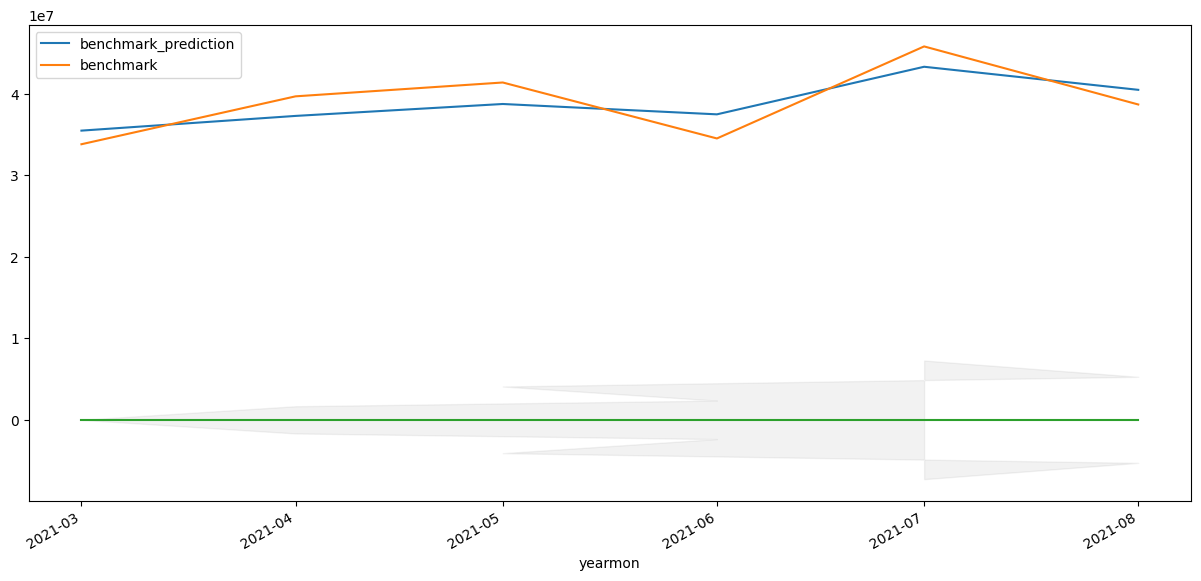

In [471]:
# produce the confidence intervals for the timeseries

prediction_ci = predictions.conf_int()
ax = benchmark_pred_df.plot(label = "benchmark", figsize=(15, 7))
predictions.predicted_mean.plot(ax = ax,alpha = 1)
ax.fill_between(prediction_ci.index, 
                prediction_ci.iloc[:, 0], 
                prediction_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

In [476]:
#rename the benchmark data in the format for the forecast, specific to prophet package

benchmark_pred_ts = benchmark_pred_df
benchmark_pred_ts = benchmark_pred_ts.reset_index()
benchmark_pred_ts.columns = ["ds","y", "observed"]

benchmark_pred_ts

,ds,y,observed
0,2021-03-01,35494044.0,33822787.61
1,2021-04-01,37298564.0,39701515.10
2,2021-06-01,37491460.0,34532116.99
3,2021-05-01,38761956.0,41399845.79
4,2021-08-01,40499828.0,38700705.03
5,2021-07-01,43330912.0,45826968.51


In [477]:
# install packages for forecasting a year point forward based on the results of the boosting model
from prophet import Prophet

forecast = Prophet()
forecast_pred = forecast.fit(benchmark_pred_ts)

forecast_results = forecast.make_future_dataframe(periods = 24, freq = "M")
fore_predictions = forecast.predict(forecast_results)

# print the forecasting values as well as upper and lower bounds in comparison
fore_predictions[["ds", "yhat", "yhat_lower", "yhat_upper"]]



22:19:07 - cmdstanpy - INFO - Chain [1] start processing
22:19:07 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2021-03-01,3.582457e+07,3.409410e+07,3.782883e+07
1,2021-04-01,3.703576e+07,3.522558e+07,3.896544e+07
2,2021-05-01,3.820788e+07,3.636266e+07,4.019551e+07
3,2021-06-01,3.941906e+07,3.754328e+07,4.138152e+07
4,2021-07-01,4.059118e+07,3.856635e+07,4.242512e+07
5,2021-08-01,4.180237e+07,3.978079e+07,4.347711e+07
6,2021-08-31,4.297449e+07,4.112480e+07,4.482739e+07
7,2021-09-30,4.414661e+07,4.212911e+07,4.609473e+07
8,2021-10-31,4.535780e+07,4.342488e+07,4.738105e+07
9,2021-11-30,4.652991e+07,4.477468e+07,4.847873e+07



3. What is the projected household penetration for the given year? Household penetration is defined as (# Households Involved in Purchase / Total US Households)


In [478]:
# time box the forecast predictions for a year time period

spend_predict = pd.DataFrame(fore_predictions[["ds", "yhat"]])
spend_predict = spend_predict[(spend_predict["ds"] > "2021-08-01") & (spend_predict["ds"] < "2022-10-01")]
spend_predict

,ds,yhat
6,2021-08-31,4.297449e+07
7,2021-09-30,4.414661e+07
8,2021-10-31,4.535780e+07
9,2021-11-30,4.652991e+07
10,2021-12-31,4.774110e+07
11,2022-01-31,4.895229e+07
12,2022-02-28,5.004627e+07
13,2022-03-31,5.125746e+07
14,2022-04-30,5.242958e+07
15,2022-05-31,5.364076e+07


In [479]:
# compute the yearly sum of sales based on the predictions

predicted_sum = int(spend_predict['yhat'].sum())
predicted_sum


709555856

In [488]:
prop_table

,yearmon,agg_total_spent,benchmark,coverage_rate,sales_proportion
0,2021-03,12110.894493,33822787.61,0.035807,2621
1,2021-04,8222.600802,39701515.10,0.020711,2748
2,2021-05,8543.070035,41399845.79,0.020636,2876
3,2021-06,8271.714083,34532116.99,0.023954,2840
4,2021-07,9641.110647,45826968.51,0.021038,3266
5,2021-08,8976.602883,38700705.03,0.023195,2989


In [512]:
# approximate the averge proportion of sales in comparison to the benchmark using the individual user sales proportions
# in comparison to the total monthly sales. In this case the average coverage rate is a good estimate for the reciept penetration 

prop_table['coverage_rate'].mean() * 100


2.4223359959396507

In [507]:
# using the metrics used to estimate household penetration, estimate how the individual receipt collection
# of the recorded sales is reflected as a proportion of the benchmark to understand the reciept penetration.

pred_merge.groupby(['yearmon'])['sales_proportion'].count().sort_values()

prop_table = sum_sales.merge(pred_merge.groupby(['yearmon'])['sales_proportion'].count().sort_values(), on = "yearmon")
prop_table

recept_penetration = ((prop_table['sales_proportion']/prop_table['coverage_rate']) / prop_table['benchmark'] * 100).mean()
recept_penetration



0.317056303475668